**Imports**

In [5]:
# Standard Imports
import random

# 3rd Party
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from pgmpy.estimators import PC
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Synthcity
from synthcity.plugins.core.dataloader import GenericDataLoader

# Goggle
from goggle.GoggleModel import GoggleModel

**Load data**

In [6]:
def preprocess_credit(df : pd.DataFrame) -> pd.DataFrame:

    replace = [
        ['A11', 'A12', 'A13', 'A14'],
        ['A30', 'A31','A32','A33','A34','A35'],
        ['A40','A41','A42','A43','A44','A45','A46','A47','A48','A49','A410'],
        ['A61','A62','A63','A64','A65'],
        ['A71','A72','A73','A74','A75'],
        ['A91','A92','A93','A94','A95'],
        ['A101','A102','A103'],
        ['A121','A122','A123','A124'],
        ['A141','A142','A143'],
        ['A151','A152','A153'],
        ['A171','A172','A173','A174'],
        ['A191','A192'],
        ['A201','A202']
    ]

    for row in replace:
        df = df.replace(row, range(len(row)))

    ind = list(range(len(df.columns)))

    ind = [x for x in ind if x != df.columns.get_loc('target')]
    col_list = df.columns[ind]

    ct = ColumnTransformer(
        [("scaler", StandardScaler(), col_list)], remainder="passthrough"
    )

    df = pd.DataFrame(ct.fit_transform(df),
                      index=df.index, columns=df.columns)

    return df


In [7]:
dataset = "credit"
names = [ 
    'status',
    'duration',
    'credit_history',
    'purpose',
    'credit_amount',
    'savings_account',
    'present_employment',
    'installment_rate',
    'personal_status',
    'other_debtors',
    'residence',
    'property',
    'age',
    'other_installment_plans',
    'housing',
    'number_of_existing_credits',
    'job',
    'liable_people',
    'telephone',
    'foreign_worker',
    'target'
]

X = pd.read_csv("../data/german.data", header=None, sep=' ', names=names)
X = preprocess_credit(X)

X["target"] = X["target"] - 1.0
X = X.dropna(axis=0)
ind = list(range(len(X.columns)))
ind = [x for x in ind if x != X.columns.get_loc("target")]
col_list = X.columns[ind]

ct = ColumnTransformer(
    [("scaler", StandardScaler(), col_list)], remainder="passthrough"
)

X_ = ct.fit_transform(X)
X = pd.DataFrame(X_, index=X.index, columns=X.columns)

X.head()

,status,duration,credit_history,purpose,credit_amount,savings_account,present_employment,installment_rate,personal_status,other_debtors,...,property,age,other_installment_plans,housing,number_of_existing_credits,job,liable_people,telephone,foreign_worker,target
0,-1.254566,-1.236478,1.344014,0.062704,-0.745131,1.833169,1.338078,0.918477,0.449326,-0.303686,...,-1.293723,2.766456,0.460831,0.133710,1.027079,0.146949,-0.428290,1.214598,-0.196014,0.0
1,-0.459026,2.248194,-0.503428,0.062704,0.949817,-0.699707,-0.317959,-0.870183,-0.963650,-0.303686,...,-1.293723,-1.191404,0.460831,0.133710,-0.704926,0.146949,-0.428290,-0.823318,-0.196014,1.0
2,1.132053,-0.738668,1.344014,1.156370,-0.416562,-0.699707,0.510060,-0.870183,0.449326,-0.303686,...,-1.293723,1.183312,0.460831,0.133710,-0.704926,-1.383771,2.334869,-0.823318,-0.196014,0.0
3,-1.254566,1.750384,-0.503428,-0.301852,1.634247,-0.699707,0.510060,-0.870183,0.449326,3.885083,...,-0.341055,0.831502,0.460831,2.016956,-0.704926,0.146949,2.334869,-0.823318,-0.196014,0.0
4,-1.254566,0.256953,0.420293,-1.030963,0.566664,-0.699707,-0.317959,0.024147,0.449326,-0.303686,...,1.564281,1.535122,0.460831,2.016956,1.027079,0.146949,2.334869,-0.823318,-0.196014,1.0


**Specify ablation settings**

In [8]:
def get_adj_mat(adj_type, X, n):
    if adj_type == "ER":
        m = int(n**2 * 0.1)
        G = nx.gnm_random_graph(n, m)
        adj_mat = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if (i, j) in list(G.edges):
                    adj_mat[i][j] = 1
    elif adj_type == "COV":
        adj_mat = abs(np.corrcoef(X.to_numpy().T))
    elif adj_type == "BN":
        c = PC(X)
        model = c.estimate(variant="parallel", max_cond_vars=3, ci_test="pearsonr")
        adj_mat = np.zeros((n, n))
        for i, col_name_i in enumerate(X.columns):
            for j, col_name_j in enumerate(X.columns):
                if (col_name_i, col_name_j) in model.edges():
                    adj_mat[i][j] = 1
    else:
        adj_mat = np.ones((n, n))

    plt.figure(figsize=(4, 4))
    im = plt.imshow(adj_mat, cmap="inferno", interpolation="nearest", vmin=0, vmax=1.0)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Prior graph")
    plt.axis("off")
    plt.show()
    return adj_mat

**Fit model - compare ablation settings**



Considering ablation setting: ER


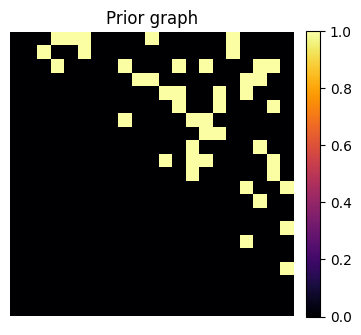

[Epoch 100/1000, patience 41] train: 18.965, val: 18.575
Training terminated after 171 epochs
Quality: 0.271
Detection: 0.823
Performance on real: 0.580, on synth: 0.535, diff: 0.045


Considering ablation setting: COV


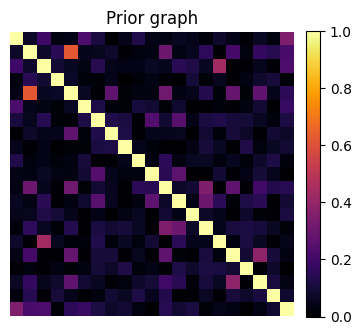

[Epoch 100/1000, patience 27] train: 18.938, val: 18.563
Training terminated after 122 epochs
Quality: 0.293
Detection: 0.863
Performance on real: 0.580, on synth: 0.546, diff: 0.034


Considering ablation setting: BN


Working for n conditional variables: 3: 100%|██████████| 3/3 [00:10<00:00,  3.49s/it]


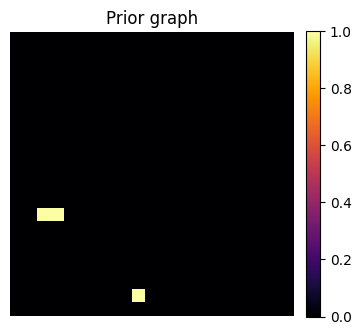

[Epoch 100/1000, patience 27] train: 18.953, val: 18.577
Training terminated after 122 epochs
Quality: 0.301
Detection: 0.807
Performance on real: 0.580, on synth: 0.549, diff: 0.031


Considering ablation setting: DENSE


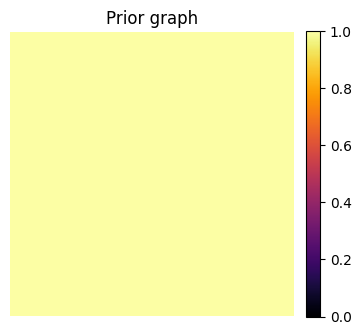

[Epoch 100/1000, patience 23] train: 19.049, val: 18.649
Training terminated after 126 epochs
Quality: 0.249
Detection: 0.848
Performance on real: 0.580, on synth: 0.466, diff: 0.114


In [9]:
X_train, X_test = train_test_split(X, random_state=0, test_size=0.2, shuffle=True)

for adj_type in ["ER", "COV", "BN", "DENSE"]:
    print(f"\n\nConsidering ablation setting: {adj_type}")
    adj_mat = get_adj_mat(adj_type, X, n=X_train.shape[1])
    gen = GoggleModel(
        ds_name=dataset,
        input_dim=X_train.shape[1],
        encoder_dim=64,
        encoder_l=2,
        het_encoding=True,
        decoder_dim=64,
        decoder_l=2,
        threshold=0.1,
        het_decoder=False,
        graph_prior=torch.Tensor(adj_mat),
        prior_mask=torch.ones_like(torch.Tensor(adj_mat)),
        device="cpu",
        beta=0.1,
        seed=0,
    )
    gen.fit(X_train)
    X_synth = gen.sample(X_test)

    X_synth_loader = GenericDataLoader(
        X_synth,
        target_column="target",
    )
    X_test_loader = GenericDataLoader(
        X_test,
        target_column="target",
    )

    res = gen.evaluate_synthetic(X_synth_loader, X_test_loader)
    print(f"Quality: {res[0]:.3f}")
    print(f"Detection: {res[2]:.3f}")
    print(
        f"Performance on real: {res[1][0]:.3f}, on synth: {res[1][1]:.3f}, diff: {(res[1][0] - res[1][1]):.3f}"
    )